<a href="https://colab.research.google.com/github/nahumsa/DM-Reconstruction/blob/master/Reconstruct%20DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconstruction of a density matrix

### Import dependencies for Google Colab

In [0]:
! git clone https://github.com/nahumsa/DM-Reconstruction

In [0]:
!pip install qutip

In [0]:
% cd DM-Reconstruction/

##Import Dependencies

In [0]:
try:
  %tensorflow_version 2.x

except Exception:
  pass
  
import tensorflow as tf

#Set Random Seed for reproduction
tf.random.set_seed(1234)

# Remove warnings
import logging
logging.getLogger('tensorflow').disabled = True

#Use this to not need to initialize tensors outside session
tf.config.experimental_run_functions_eagerly(True)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import qutip
from tqdm.notebook import tqdm

## Creating dataset

In [0]:
from Utils.Dataset import create_dataset

samples_train = 5000
states_train, measurements_train, labels_train = create_dataset(samples_train)

samples_test = 3000
states_test, measurements_test, labels_test = create_dataset(samples_test)

In [0]:
from Utils.Dataset import create_x

#Transforming in an np.array
X_train = np.array(create_x(measurements_train))
Y_train = np.array(labels_train)

X_test = np.array(create_x(measurements_test))
Y_test = np.array(labels_test)

print(f"Shape of the Training: \n X: {X_train.shape}")

Shape of the Training: 
 X: (5000, 15)


# Models

## VAE With Linear output and MSE loss function

### Choosing Running Folder

In [0]:
import os
# run params
SECTION = 'bvae'
RUN_ID = '0001'
DATA_NAME = 'Entanglement'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

### Defining the model

In [0]:
from Models.VAE_Keras import DenseVariationalAutoencoderKeras

#Parameters
input_dimension = (X_train.shape[1],)
encoder_dense = [512,256,128,52]
decoder_dense = [52,128,256, 512, X_train.shape[1]]
batch_norm = False
dropout = True
ZDIM = 5

#Defining the Beta-VAE
bvae = DenseVariationalAutoencoderKeras(input_dim = input_dimension
                                        , encoder_dense_units = encoder_dense
                                        , decoder_dense_units = decoder_dense
                                        , z_dim = ZDIM
                                        , use_batch_norm = batch_norm
                                        , use_dropout= dropout
                                        )

z_mu_b = bvae.encoder.predict(X_test)

### Training the model

In [0]:
#Compile Parameters (These parameters depend on a fine tuning) 
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 500
BETA = 1
bvae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)

#Callbacks 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_LR = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=5, 
                              verbose=1, 
                              mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, min_lr=0)


callbacks = [reduce_LR]

# Training Parameters
BATCH_SIZE = 256
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

history = bvae.train( x_train = X_train
                    , y_train = X_train
                    , batch_size = BATCH_SIZE
                    , validation_data = (X_test, X_test)
                    , epochs = EPOCHS
                    , run_folder = RUN_FOLDER
                    , print_every_n_batches = PRINT_EVERY_N_BATCHES
                    , initial_epoch = INITIAL_EPOCH                    
                    , callbacks = callbacks
                    )

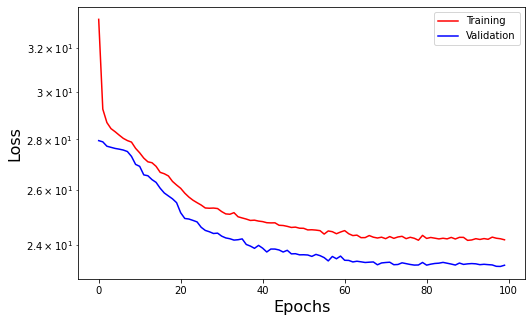

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

#Epochs
epochs = np.arange(INITIAL_EPOCH, EPOCHS, 1)

fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.set_yscale('log')
ax1.legend()
plt.show()

### Reconstruction plot

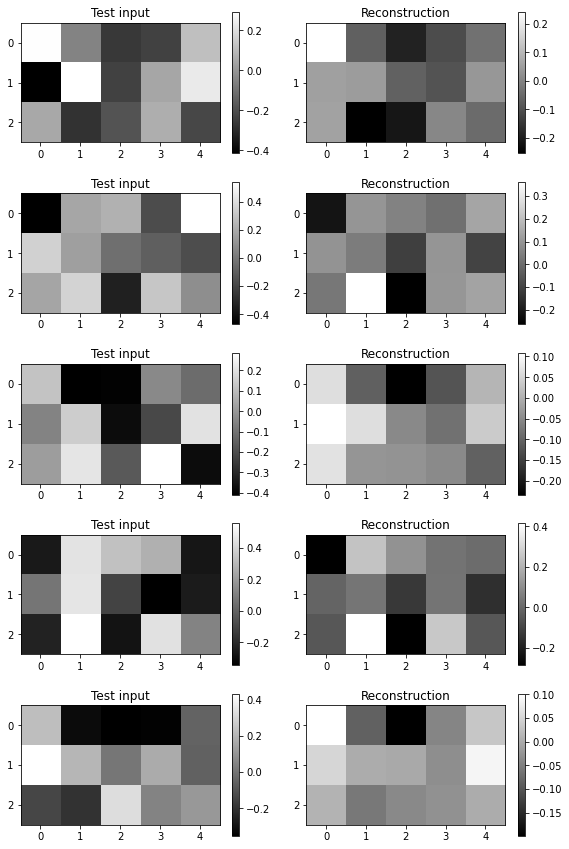

In [0]:
n_to_show = 5
example_idx = np.random.choice(range(len(X_test)), n_to_show)
example_images = X_test[example_idx]

z_points = bvae.encoder.predict(example_images)

reconst_images = bvae.decoder.predict(z_points)

plt.figure(figsize=(8, 12))
for i in range(n_to_show):

    plt.subplot(5, 2, 2*i + 1)    
    plt.imshow(example_images[i].reshape(3, 5), cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(reconst_images[i].reshape(3, 5), cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    
plt.tight_layout()

## Using Trace distance as a loss function

### Building the model

In [0]:
#Helper functions from mitdeeplearning
import time
from IPython import display as ipythondisplay
from string import Formatter

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):
    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale
    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)

      elif self.scale == 'semilogx':
        plt.semilogx(data)

      elif self.scale == 'semilogy':
        plt.semilogy(data)

      elif self.scale == 'loglog':
        plt.loglog(data)
      
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

In [0]:
from itertools import product

def tf_kron(a: tf.Tensor,
            b: tf.Tensor) -> tf.Tensor:

  """Calculates the Kronocker product of two matrices ((2,2) Tensors).

  Parameters
  -----------------------------------------------------------------------
  a(tf.Tensor): Tensor on the left of the product.
  b(tf.Tensor): Tensor on the right of the product.

  Return
  -----------------------------------------------------------------------
  (tf.tensor): Kronocker product between a and b.

  """
  assert len(a.shape) == 2
  assert len(b.shape) == 2
  a_shape = list(b.shape)    
  b_shape = list(b.shape)
  return tf.reshape(tf.reshape(a,[a_shape[0],1,a_shape[1],1])*tf.reshape(b,[1,b_shape[0],1,b_shape[1]]),[a_shape[0]*b_shape[0],a_shape[1]*b_shape[1]])


#Creating pauli matrices
sigma_0_np = np.array([[1.,0.],
                      [0.,1.]], dtype=np.complex64)

sigma_1_np = np.array([[0.,1.],
                       [1.,0.]], dtype=np.complex64)

sigma_2_np = np.array([[0.,1.j],
                       [-1.j,0.]], dtype=np.complex64)

sigma_3_np = np.array([[1.,0.],
                       [0.,-1.]], dtype=np.complex64)

#Converting to tensors
sigma_0 = tf.Variable(sigma_0_np, tf.complex64)

sigma_1 = tf.Variable(sigma_1_np, tf.complex64)

sigma_2 = tf.Variable(sigma_2_np, tf.complex64)

sigma_3 = tf.Variable(sigma_3_np, dtype=tf.complex64)

def create_2qubit_density_mat(measurements: tf.Variable) -> tf.Variable:
  
  name_basis_1 = ['I', 'X', 'Y', 'Z']
  basis_1 = [sigma_0, sigma_1,sigma_2,sigma_3]
  name_basis_2 = []
  basis_2 = []
  for (name_1, meas_1),(name_2,meas_2) in product(zip(name_basis_1, basis_1),zip(name_basis_1, basis_1)):
    if name_1 == 'I' and name_2 == 'I':
      pass
    else:
      basis_2.append(tf_kron(meas_1,meas_2))
      name_basis_2.append(name_1 + name_2)
  
  basis_2_tf = tf.Variable(basis_2, name='Basis')
  
  # Helper to make tr(density_matrix) = 1
  
  ones_II = tf.ones((tf.shape(measurements)[0],1), dtype=tf.dtypes.complex64)  
  II = tf.Variable([tf_kron(sigma_0 , sigma_0)], name='II')
  
  density_matrix = 0.25*(tf.tensordot(ones_II , II ,axes=1) + tf.tensordot(measurements,basis_2_tf,axes=1))
  return density_matrix

def trace_dist(A,B):
  dif = tf.math.subtract(A,B)  
  dif = tf.transpose(dif, conjugate=True, perm=[0,2,1]) * dif  
  vals = tf.linalg.eigvalsh(dif)
  return tf.math.real(0.5*tf.reduce_sum(tf.math.sqrt(tf.math.abs(vals)),axis=-1))

def trace_loss(y_true,y_pred):
  y_true = tf.cast(y_true, tf.dtypes.complex64, name='Casting_true')
  y_pred = tf.cast(y_pred, tf.dtypes.complex64, name='Casting_pred')
  d_y_true = create_2qubit_density_mat(y_true)  
  d_y_pred = create_2qubit_density_mat(y_pred)    
  return tf.reduce_mean(trace_dist(d_y_pred,d_y_true))

In [0]:
from tensorflow.keras import layers

class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(layers.Layer):
  """Maps Input to a triplet (z_mean, z_log_var, z)."""

  def __init__(self,
               latent_dim=32,
               intermediate_dim=64,
               dtype='float64',
               **kwargs):
    
    super(Encoder, self).__init__(**kwargs)
    self.dense_proj = []
    for i in intermediate_dim:
      self.dense_proj.append(layers.Dense(i,
                                          activation=tf.nn.relu))
    

    self.dense_mean = layers.Dense(latent_dim)
    self.dense_log_var = layers.Dense(latent_dim)
    self.sampling = Sampling()

  def call(self, inputs):
    x = self.dense_proj[0](inputs)
    
    for lay in self.dense_proj[1:]:
      x = lay(x)
    
    z_mean = self.dense_mean(x)
    z_log_var = self.dense_log_var(x)
    z = self.sampling((z_mean, z_log_var))
    return z_mean, z_log_var, z

class Decoder(layers.Layer):
  """Converts z, the encoded digit vector, back into a readable digit."""

  def __init__(self,
               original_dim,
               intermediate_dim=64,               
               **kwargs):
    super(Decoder, self).__init__(**kwargs)

    self.dense_proj = []
    for i in intermediate_dim:
      self.dense_proj.append(layers.Dense(i,
                                          activation=tf.nn.relu))
    
    self.dense_output = layers.Dense(original_dim)

  def call(self, inputs):
    x = self.dense_proj[0](inputs)
    
    for lay in self.dense_proj[1:]:
      x = lay(x)

    return self.dense_output(x)

In [0]:
class VariationalAutoEncoder(tf.keras.Model):
  """Combines the encoder and decoder into an end-to-end model for training."""

  def __init__(self,
               original_dim,
               intermediate_dim=64,
               latent_dim=32,
               **kwargs):
    
    super(VariationalAutoEncoder, self).__init__(**kwargs)
    self.original_dim = original_dim
    self.encoder = Encoder(latent_dim=latent_dim,
                           intermediate_dim=intermediate_dim)
    self.decoder = Decoder(original_dim, 
                           intermediate_dim=intermediate_dim)

  def call(self, inputs):
    z_mean, z_log_var, z = self.encoder(inputs)
    reconstructed = self.decoder(z)
    # Add KL divergence regularization loss.
    kl_loss = - 0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)    
    self.add_loss(kl_loss)
    return reconstructed

In [0]:
@tf.function
def training_step(x, VAE, optimizer,
                  r_loss, beta):
  """Training step for the VAE.
  
  Parameters
  -------------------------------------------
  x: Data
  VAE(tf.keras.Model): Variational Autoencoder model. 
  optimizer(tf.keras.optimizer): Optimizer used.  
  r_loss(float): Parameter controlling reconstruction loss.
  beta(float): Parameter controlling the KL divergence.

  Return:
  Loss(float): Loss value of the training step.

  """
  with tf.GradientTape() as tape:
      reconstructed = VAE(x)  # Compute input reconstruction.
      # Compute loss.
      loss = trace_loss(x, reconstructed)
      kl = sum(VAE.losses)
      loss = r_loss * loss + beta*kl  
  # Update the weights of the VAE.
  grads = tape.gradient(loss, VAE.trainable_weights)
  optimizer.apply_gradients(zip(grads, VAE.trainable_weights))
  return loss

def training(dataset, VAE, optimizer, 
             epochs, r_loss, beta,              
             Plotter=None):
  """ Training of the Variational Autoencoder for a 
  tensorflow.dataset.

  Parameters
  -------------------------------------------
  dataset(tf.data.Dataset): Dataset of the data.
  VAE(tf.keras.Model): Variational Autoencoder model.
  epochs(int): Number of epochs.
  r_loss(float): Parameter controlling reconstruction loss.
  beta(float): Parameter controlling the KL divergence.  
  Plotter(object): Plotter object to show how the training is
                  going (Default=None).

  """

  losses = []
  epochs = range(epochs)

  for i in tqdm_notebook(epochs, desc='Epochs'):
    losses_epochs = []
    for step, x in enumerate(dataset):

      loss = training_step(x, VAE, optimizer, r_loss, beta)
  
      # Logging.
      losses_epochs.append(float(loss))
    losses.append(np.mean(losses_epochs))
    
    if Plotter != None:
      Plotter.plot(losses)

  return losses  

In [0]:
ZDIM = 20
input_dim = X_train.shape[1]
hidden_dims = [64,128,256]
batchsize = 32

vae = VariationalAutoEncoder(original_dim=input_dim,
                             intermediate_dim=hidden_dims,
                             latent_dim=ZDIM)

# Optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Prepare a dataset.
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)

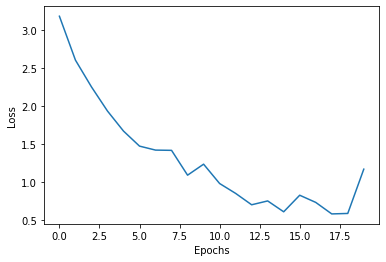

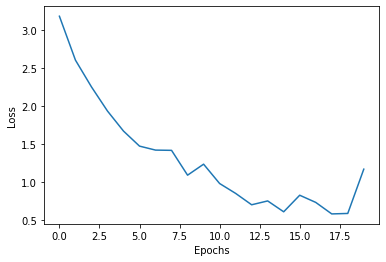

In [0]:
r_loss = 10.
beta = 1e-2
epochs = 20

# Periodic Plotter for loss
plotter = PeriodicPlotter(sec=5, xlabel='Epochs', ylabel='Loss')

# Optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

loss_epochs = training(dataset, vae, optimizer, epochs, r_loss, beta, Plotter=plotter)

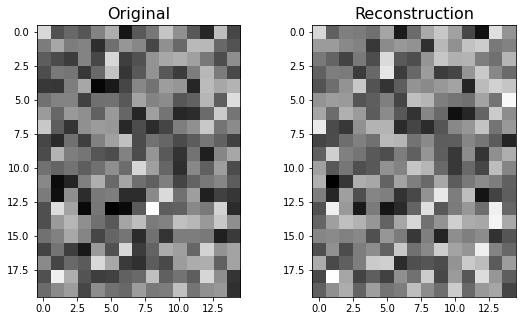

In [0]:
fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])


ax1.imshow((X_train[0:20]), cmap="gray")
ax1.set_title('Original', size=16)

ax2.imshow(vae.predict(X_train[0:20]), cmap="gray")
ax2.set_title('Reconstruction', size=16)

#z_mean, z_log_var, z = vae.encoder(X_test)
#z = z.numpy()

#ax3 = fig.add_subplot(gs[0, 2])
#ims = ax3.scatter(z[:,0], z[:,1], c=Y_test)
#ax3.set_title('Latent Space', size=16)
#plt.colorbar(ims, ax=ax3)

plt.show()